<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/11.human_face_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **생성자**

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 잠재공간 상의 특징 하나를 받는다.
        # 이때 여기서는 그 잠재공간의 차원이 100차원이라고 가정한다.

        # 생성자를 구성하는 층 정의
        self.gen = nn.Sequential(
            # 기본블럭 형태: 업샘플링 -> 배치정규화 -> ReLU
            nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

## **감별자 정의**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 감별자를 구성하는 층의 정의
        self.disc = nn.Sequential(
            # 기본블럭 형태: 합성곱 -> 배치정규화 -> LeakyReLU
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

## **GAN의 가중치 초기화**
- GAN은 특징 공간을 학습하는 것으로 보기 때문에 학습하기 더 어렵다.
- 학습을 원활하게 이루어질 수 있도록 가중치의 초기화를 설정한다.

In [ ]:
def weights_init(m):
   # 층의 종류 추출
   classname = m.__class__.__name__
   if classname.find('Conv') != -1:
       # 합성곱층 초기화
       nn.init.normal_(m.weight.data, 0.0, 0.02)
   elif classname.find('BatchNorm') != -1:
       # 배치정규화층 초기화
       nn.init.normal_(m.weight.data, 1.0, 0.02)
       nn.init.constant_(m.bias.data, 0)

## **학습에 필요한 요소 정의**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 생성자 정의
G = Generator().to(device)
# ❶ 생성자 가중치 초기화
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
# ❷ 감별자 가중치 초기화
D.apply(weights_init)

import tqdm

from torch.optim.adam import Adam

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

## **학습**

In [ ]:
for epochs in range(50):
   iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))

   for i, data in iterator:
       D_optim.zero_grad()

       # ➊ 실제 이미지에는 1, 생성된 이미지는 0으로 정답을 설정
       label = torch.ones_like(data[1], dtype=torch.float32).to(device)
       label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

       # ➋ 실제 이미지를 감별자에 입력
       real = D(data[0].to(device))

       # ❸ 실제 이미지에 대한 감별자의 오차를 계산
       Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
       Dloss_real.backward()
       # ➊ 가짜 이미지 생성
       noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
       fake = G(noise)

       # 가짜 이미지를 감별자에 입력
       output = D(fake.detach())

       # 가짜 이미지에 대한 감별자의 오차를 계산
       Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
       Dloss_fake.backward()

       # ➋ 감별자의 전체 오차를 학습
       Dloss = Dloss_real + Dloss_fake
       D_optim.step()
       # ➊ 생성자의 학습
       G_optim.zero_grad()
       output = D(fake)
       Gloss = nn.BCELoss()(torch.squeeze(output), label)
       Gloss.backward()

       G_optim.step()

       iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "Generator.pth")
torch.save(D.state_dict(), "Discriminator.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


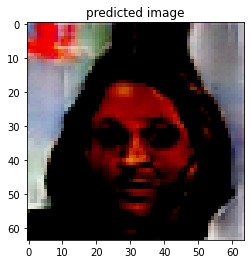

In [ ]:
with torch.no_grad():
   G.load_state_dict(
       torch.load("./Generator.pth", map_location=device))

   # 특징 공간 상의 랜덤한 하나의 점을 지정
   feature_vector = torch.randn(1, 100, 1, 1).to(device)
   # 이미지 생성
   pred = G(feature_vector).squeeze()
   pred = pred.permute(1, 2, 0).cpu().numpy()

   plt.imshow(pred)
   plt.title("predicted image")
   plt.show()